In [1]:
# Cell 1: Imports and Setup
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import timm
import cv2

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

Using Apple MPS
Device: mps
PyTorch version: 2.9.1
Timm version: 1.0.22


In [2]:
# Cell 2: Configuration (EfficientNet-V2-S Optimized)
class Config:
    # Paths - Approach 4
    BASE_DIR = '/Users/yashbansal/Documents/cdc/Approach_4'
    DATA_DIR = os.path.join(BASE_DIR, 'data')
    PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
    RAW_DIR = os.path.join(DATA_DIR, 'raw')
    TEST_IMG_DIR = os.path.join(DATA_DIR, 'test_data_images')
    
    # Image paths - Only Zoom 20
    TRAIN_IMG_20 = os.path.join(RAW_DIR, 'train_images_20')
    TEST_IMG_20 = os.path.join(TEST_IMG_DIR, 'test_images_20')
    
    # Output paths
    OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
    EXPLAINABILITY_DIR = os.path.join(BASE_DIR, 'Explainability')
    MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'best_model.pth')
    PREDICTIONS_PATH = os.path.join(OUTPUT_DIR, 'test_predictions.csv')
    
    # ========== EfficientNet-V2-S Settings ==========
    IMG_SIZE = 224  # Sweet spot for EfficientNet-V2
    ORIGINAL_IMG_SIZE = 1280
    
    # Backbone
    BACKBONE = 'tf_efficientnetv2_s'
    
    # FPN output channels
    FPN_OUT_CHANNELS = 128
    
    # CBAM
    CBAM_REDUCTION = 16
    
    # Tabular MLP
    TAB_HIDDEN_DIMS = [128, 128]
    TAB_OUTPUT_DIM = 64
    TAB_DROPOUT = 0.3
    
    # Fusion head
    FUSION_HIDDEN = [256, 64]
    FUSION_DROPOUT = 0.2
    
    # Training
    BATCH_SIZE = 64  # EfficientNet uses more memory than ConvNeXt
    EPOCHS = 25
    LR_HEAD = 3e-4
    WEIGHT_DECAY = 1e-5
    WARMUP_EPOCHS = 2
    EARLY_STOPPING_PATIENCE = 8
    
    # Tabular dropout
    TABULAR_DROPOUT = 0.2
    
    # Loss
    HUBER_DELTA = 1.0

config = Config()

# Create output directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.EXPLAINABILITY_DIR, exist_ok=True)
os.makedirs(os.path.join(config.EXPLAINABILITY_DIR, 'validation'), exist_ok=True)
os.makedirs(os.path.join(config.EXPLAINABILITY_DIR, 'test'), exist_ok=True)

print("Configuration loaded!")
print(f"Backbone: {config.BACKBONE}")
print(f"Image size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")

Configuration loaded!
Backbone: tf_efficientnetv2_s
Image size: 224x224
Batch size: 64


In [3]:
# Cell 3: Load and Explore Data
# Load CSV files
train_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'train_processed.csv'))
val_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'val_processed.csv'))
test_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'test_processed.csv'))

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"\nTrain head:\n{train_df.head(2)}")

Train samples: 12967
Validation samples: 3242
Test samples: 5404

Train columns: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'property_age', 'was_renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'has_view', 'is_luxury', 'distance_from_seattle', 'price_log', 'price', 'id', 'lat', 'long', 'image_exists', 'image_path']

Train head:
   bedrooms  bathrooms    floors  waterfront      view  condition     grade  \
0 -0.404751   0.507395 -0.918626   -0.083788 -0.306964   0.908842 -0.557611   
1  0.699915   0.834941  0.922943   -0.083788 -0.306964  -0.626000 -0.557611   

   sqft_living_log  sqft_lot_log  sqft_above_log  ...  has_view  is_luxury  \
0         0.339313      0.251916       -0.127334  ... -0.331514  -0.207647   
1         1.003003     -0.242640        0.533037  ... -0.331514  -0.207647   

   distance_from_seattle  p

In [4]:
# Cell 4: Define Feature Columns
# Columns to exclude (metadata and target)
EXCLUDE_COLS = ['id', 'lat', 'long', 'image_exists', 'image_path', 'price', 'price_log']

# Get feature columns (all columns except excluded ones)
TABULAR_FEATURES = [col for col in train_df.columns if col not in EXCLUDE_COLS]
NUM_FEATURES = len(TABULAR_FEATURES)

print(f"Number of tabular features: {NUM_FEATURES}")
print(f"Features: {TABULAR_FEATURES}")

# Target column
TARGET_COL = 'price_log'
print(f"\nTarget column: {TARGET_COL}")
print(f"Target stats - Min: {train_df[TARGET_COL].min():.4f}, Max: {train_df[TARGET_COL].max():.4f}, Mean: {train_df[TARGET_COL].mean():.4f}")

Number of tabular features: 21
Features: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'property_age', 'was_renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'has_view', 'is_luxury', 'distance_from_seattle']

Target column: price_log
Target stats - Min: 11.2252, Max: 15.8567, Mean: 13.0461


In [5]:
# Cell 5: Image Transforms (Simplified for Speed)
# Training transforms - minimal augmentation
train_transform = T.Compose([
    T.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms
val_transform = T.Compose([
    T.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Transforms defined! Image size: {config.IMG_SIZE}x{config.IMG_SIZE}")

Transforms defined! Image size: 224x224


In [6]:
# Cell 6: Dataset Class (Optimized)
class PropertyDataset(Dataset):
    """Optimized dataset with faster image loading."""
    
    def __init__(self, df, img_dir, features, target_col=None, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.features = features
        self.target_col = target_col
        self.transform = transform
        self.is_test = is_test
        
        # Pre-compute valid indices and paths
        self.valid_indices = []
        self.img_paths = []
        
        for idx in range(len(self.df)):
            prop_id = self.df.loc[idx, 'id']
            img_path = os.path.join(self.img_dir, f"{prop_id}_z20.jpg")
            
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
                self.img_paths.append(img_path)
        
        # Pre-extract tabular data as numpy array for faster access
        self.tabular_data = self.df.iloc[self.valid_indices][self.features].values.astype(np.float32)
        self.prop_ids = self.df.iloc[self.valid_indices]['id'].values.astype(np.int64)
        
        if not is_test and target_col:
            self.targets = self.df.iloc[self.valid_indices][target_col].values.astype(np.float32)
        else:
            self.targets = None
        
        print(f"Dataset: {len(self.valid_indices)}/{len(self.df)} samples")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Fast image loading
        img = Image.open(self.img_paths[idx]).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # Pre-extracted tabular data (faster)
        tabular = torch.from_numpy(self.tabular_data[idx])
        prop_id = self.prop_ids[idx]
        
        if self.is_test:
            return img, tabular, prop_id
        else:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return img, tabular, target, prop_id

print("PropertyDataset defined (optimized)!")

PropertyDataset defined (optimized)!


In [7]:
# Cell 7: Create Datasets and DataLoaders (Fixed for Jupyter/macOS)
# Training dataset
train_dataset = PropertyDataset(
    df=train_df,
    img_dir=config.TRAIN_IMG_20,
    features=TABULAR_FEATURES,
    target_col=TARGET_COL,
    transform=train_transform,
    is_test=False
)

# Validation dataset
val_dataset = PropertyDataset(
    df=val_df,
    img_dir=config.TRAIN_IMG_20,
    features=TABULAR_FEATURES,
    target_col=TARGET_COL,
    transform=val_transform,
    is_test=False
)

# Test dataset
test_dataset = PropertyDataset(
    df=test_df,
    img_dir=config.TEST_IMG_20,
    features=TABULAR_FEATURES,
    target_col=None,
    transform=val_transform,
    is_test=True
)

# DataLoaders - num_workers=0 for Jupyter compatibility on macOS
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Must be 0 for Jupyter on macOS
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Dataset: 12967/12967 samples
Dataset: 3242/3242 samples
Dataset: 5404/5404 samples

Train samples: 12967
Validation samples: 3242
Test samples: 5404

Train batches: 203
Validation batches: 51
Test batches: 85


In [8]:
# Cell 8: Tabular MLP Encoder (Fixed)
class TabularMLP(nn.Module):
    """Simple MLP encoder for tabular features."""
    
    def __init__(self, num_features, hidden_dims=[128, 256, 128], output_dim=128, dropout=0.3):
        super().__init__()
        
        layers = []
        in_dim = num_features
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),  # Use LayerNorm instead of BatchNorm1d
                nn.GELU(),  # GELU often works better than ReLU
                nn.Dropout(dropout)
            ])
            in_dim = hidden_dim
        
        # Output layer
        layers.extend([
            nn.Linear(in_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.GELU()
        ])
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        # Ensure contiguous tensor
        x = x.contiguous()
        return self.mlp(x)

print("TabularMLP defined!")

TabularMLP defined!


In [9]:
# Cell 9: CBAM (Simplified for Speed)
class CBAM(nn.Module):
    """Simplified CBAM - channel attention only (faster, still effective)."""
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.size()
        # Channel attention only (skip spatial for speed)
        y = self.avg_pool(x).view(B, C)
        y = self.fc(y).view(B, C, 1, 1)
        return x * y.expand_as(x)

print("CBAM (simplified) defined!")

CBAM (simplified) defined!


In [10]:
# Cell 10: FPN-Lite (Simplified for Speed)
class FPNLite(nn.Module):
    """Minimal FPN - just lateral connection and add."""
    
    def __init__(self, c3, c4, out_channels=128):
        super().__init__()
        self.lateral3 = nn.Conv2d(c3, out_channels, kernel_size=1)
        self.lateral4 = nn.Conv2d(c4, out_channels, kernel_size=1)
    
    def forward(self, f3, f4):
        p4 = self.lateral4(f4)
        p3 = self.lateral3(f3)
        
        # Upsample and add
        p4_up = F.interpolate(p4, size=p3.shape[2:], mode='nearest')
        return p3 + p4_up

print("FPNLite (simplified) defined!")

FPNLite (simplified) defined!


In [11]:
# Cell 11: EfficientNet-V2-S Backbone (BatchNorm Unfreezing)
class EfficientNetV2Backbone(nn.Module):
    """EfficientNet-V2-S backbone with BatchNorm-only unfreezing.
    
    - Fast inference (frozen conv weights)
    - BatchNorm unfreezing helps domain adaptation
    - Good for satellite imagery
    """
    
    def __init__(self, pretrained=True):
        super().__init__()
        
        # Load EfficientNet-V2-S
        self.backbone = timm.create_model(
            config.BACKBONE,  # 'tf_efficientnetv2_s'
            pretrained=pretrained,
            features_only=True,
            out_indices=(3, 4)  # Mid and high level features
        )
        
        # Get feature channels
        self.feat_channels = self.backbone.feature_info.channels()
        print(f"Feature channels: {self.feat_channels}")
        
        # Freeze everything first
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze BatchNorm parameters only (cheap & helps domain shift)
        unfrozen_count = 0
        unfrozen_params = 0
        for name, param in self.backbone.named_parameters():
            if "bn" in name.lower() or "norm" in name.lower():
                param.requires_grad = True
                unfrozen_count += 1
                unfrozen_params += param.numel()
        
        print(f"Unfroze BatchNorm layers: {unfrozen_count} parameter groups")
        print(f"Unfroze BatchNorm params: {unfrozen_params:,}")
        
        self._count_params()
    
    def _count_params(self):
        total = sum(p.numel() for p in self.backbone.parameters())
        trainable = sum(p.numel() for p in self.backbone.parameters() if p.requires_grad)
        frozen = total - trainable
        print(f"Backbone - Total: {total:,}")
        print(f"Backbone - Trainable: {trainable:,} ({100*trainable/total:.2f}%)")
        print(f"Backbone - Frozen: {frozen:,} ({100*frozen/total:.2f}%)")
    
    def forward(self, x):
        features = self.backbone(x)
        f3, f4 = features  # Stage 3 and Stage 4 outputs
        return f3, f4

print("EfficientNetV2Backbone defined!")

EfficientNetV2Backbone defined!


In [12]:
# Cell 12: Main Model (EfficientNet-V2-S)
class PropertyValueModel(nn.Module):
    """Property valuation model with EfficientNet-V2-S backbone."""
    
    def __init__(self, num_features, config):
        super().__init__()
        self.config = config
        
        # Visual backbone (EfficientNet-V2-S)
        self.backbone = EfficientNetV2Backbone(pretrained=True)
        c3, c4 = self.backbone.feat_channels  # e.g., [160, 256] for V2-S
        
        # FPN-lite
        self.fpn = FPNLite(c3, c4, out_channels=config.FPN_OUT_CHANNELS)
        
        # CBAM (channel attention only for speed)
        self.cbam = CBAM(config.FPN_OUT_CHANNELS, reduction=config.CBAM_REDUCTION)
        
        # Tabular encoder
        self.tabular_encoder = nn.Sequential(
            nn.Linear(num_features, config.TAB_HIDDEN_DIMS[0]),
            nn.LayerNorm(config.TAB_HIDDEN_DIMS[0]),
            nn.GELU(),
            nn.Dropout(config.TAB_DROPOUT),
            nn.Linear(config.TAB_HIDDEN_DIMS[0], config.TAB_OUTPUT_DIM),
            nn.LayerNorm(config.TAB_OUTPUT_DIM),
            nn.GELU()
        )
        
        # Fusion head
        fusion_input_dim = config.FPN_OUT_CHANNELS + config.TAB_OUTPUT_DIM
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_input_dim, config.FUSION_HIDDEN[0]),
            nn.LayerNorm(config.FUSION_HIDDEN[0]),
            nn.GELU(),
            nn.Dropout(config.FUSION_DROPOUT),
            nn.Linear(config.FUSION_HIDDEN[0], config.FUSION_HIDDEN[1]),
            nn.LayerNorm(config.FUSION_HIDDEN[1]),
            nn.GELU(),
            nn.Linear(config.FUSION_HIDDEN[1], 1)
        )
        
        # For Grad-CAM
        self.fpn_features = None
    
    def forward(self, img, tabular):
        # Backbone
        f3, f4 = self.backbone(img)
        
        # FPN
        fpn_out = self.fpn(f3, f4)
        self.fpn_features = fpn_out  # Store for Grad-CAM
        
        # CBAM
        cbam_out = self.cbam(fpn_out)
        
        # Global pool
        B = cbam_out.size(0)
        img_vec = F.adaptive_avg_pool2d(cbam_out, 1).reshape(B, -1)
        
        # Tabular
        tab_vec = self.tabular_encoder(tabular)
        if self.training:
            tab_vec = F.dropout(tab_vec, p=self.config.TABULAR_DROPOUT)
        
        # Fusion
        fused = torch.cat([img_vec, tab_vec], dim=1)
        output = self.fusion_head(fused).squeeze(-1)
        
        return output

print("PropertyValueModel (EfficientNet-V2-S) defined!")

PropertyValueModel (EfficientNet-V2-S) defined!


In [13]:
# Cell 13: Initialize Model and Check Parameters
model = PropertyValueModel(num_features=NUM_FEATURES, config=config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print(f"Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")

# Test forward pass
with torch.no_grad():
    test_img = torch.randn(2, 3, config.IMG_SIZE, config.IMG_SIZE).to(device)
    test_tab = torch.randn(2, NUM_FEATURES).to(device)
    out = model(test_img, test_tab)
    print(f"\nTest forward pass:")
    print(f"  Input image shape: {test_img.shape}")
    print(f"  Input tabular shape: {test_tab.shape}")
    print(f"  Output shape: {out.shape}")
    print(f"  FPN features shape: {model.fpn_features.shape}")

print("\nModel ready for training!")

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Feature channels: [160, 256]
Unfroze BatchNorm layers: 218 parameter groups
Unfroze BatchNorm params: 151,312
Backbone - Total: 19,847,248
Backbone - Trainable: 151,312 (0.76%)
Backbone - Frozen: 19,695,936 (99.24%)

Total parameters: 19,980,817
Trainable parameters: 284,881 (1.4%)
Frozen parameters: 19,695,936 (98.6%)

Test forward pass:
  Input image shape: torch.Size([2, 3, 224, 224])
  Input tabular shape: torch.Size([2, 21])
  Output shape: torch.Size([2])
  FPN features shape: torch.Size([2, 128, 14, 14])

Model ready for training!


In [14]:
# Cell 14: Loss Function and Optimizer (Simplified)
criterion = nn.HuberLoss(delta=config.HUBER_DELTA)

# All trainable params with same LR (simpler, works well)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=config.LR_HEAD, weight_decay=config.WEIGHT_DECAY)

# Simple step scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

total_trainable = sum(p.numel() for p in trainable_params)
print(f"Total trainable parameters: {total_trainable:,}")
print(f"Learning rate: {config.LR_HEAD}")

Total trainable parameters: 284,881
Learning rate: 0.0003


In [15]:
# Cell 15: Training Functions (with MPS Memory Fix)
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(loader, desc="Training")
    for batch_idx, batch in enumerate(pbar):
        img, tabular, targets, _ = batch
        img = img.to(device)
        tabular = tabular.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(img, tabular)
        loss = criterion(outputs, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * len(targets)
        all_preds.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.3f}'})
        
        # Clear MPS cache periodically
        if device.type == 'mps' and batch_idx % 25 == 0:
            torch.mps.empty_cache()
    
    avg_loss = total_loss / len(loader.dataset)
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    rmse_log = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    
    ss_res = np.sum((all_targets - all_preds) ** 2)
    ss_tot = np.sum((all_targets - np.mean(all_targets)) ** 2)
    r2_log = 1 - (ss_res / ss_tot)
    
    return avg_loss, rmse_log, r2_log


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_ids = []
    
    for batch in tqdm(loader, desc="Validating"):
        img, tabular, targets, prop_ids = batch
        img = img.to(device)
        tabular = tabular.to(device)
        targets = targets.to(device)
        
        outputs = model(img, tabular)
        loss = criterion(outputs, targets)
        
        total_loss += loss.item() * len(targets)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_ids.extend(prop_ids.numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    rmse_log = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    
    ss_res = np.sum((all_targets - all_preds) ** 2)
    ss_tot = np.sum((all_targets - np.mean(all_targets)) ** 2)
    r2_log = 1 - (ss_res / ss_tot)
    
    return avg_loss, rmse_log, r2_log, all_preds, all_ids


print("Training functions defined!")

Training functions defined!


In [25]:
# Cell 16: Grad-CAM++ Implementation (Fixed for Current Architecture)
class GradCAMPlusPlus:
    """Grad-CAM++ for EfficientNet + FPN architecture."""
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        self.hooks = []
    
    def _register_hooks(self):
        """Register hooks on FPN output (lateral4 conv)."""
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # Hook on FPN lateral4 (the main feature extraction point)
        target = self.model.fpn.lateral4
        self.hooks.append(target.register_forward_hook(forward_hook))
        self.hooks.append(target.register_full_backward_hook(backward_hook))
    
    def _remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def get_cam(self, img, tabular):
        """Generate Grad-CAM++ heatmap."""
        self.model.eval()
        
        # Store original requires_grad states
        original_states = {}
        for name, param in self.model.named_parameters():
            original_states[name] = param.requires_grad
            param.requires_grad = True
        
        self._register_hooks()
        
        # Enable gradients for input
        img = img.clone().requires_grad_(True)
        
        # Forward pass
        output = self.model(img, tabular)
        
        # Backward pass
        self.model.zero_grad()
        output.backward(retain_graph=True)
        
        if self.gradients is not None and self.activations is not None:
            # Grad-CAM++ weights
            grads = self.gradients  # (B, C, H, W)
            acts = self.activations  # (B, C, H, W)
            
            # Compute alpha (Grad-CAM++ specific)
            grads_power_2 = grads ** 2
            grads_power_3 = grads ** 3
            
            sum_acts = torch.sum(acts, dim=(2, 3), keepdim=True)
            alpha = grads_power_2 / (2 * grads_power_2 + sum_acts * grads_power_3 + 1e-8)
            
            # Weights
            weights = torch.sum(alpha * F.relu(grads), dim=(2, 3), keepdim=True)
            
            # Weighted combination
            cam = torch.sum(weights * acts, dim=1)  # (B, H, W)
            
            # ReLU and normalize
            cam = F.relu(cam)
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()
            
            result = cam.detach().cpu().numpy()
        else:
            # Fallback - return uniform attention
            result = np.ones((1, 7, 7)) * 0.5
        
        # Cleanup
        self._remove_hooks()
        for name, param in self.model.named_parameters():
            param.requires_grad = original_states[name]
        
        return result

print("GradCAMPlusPlus defined!")

GradCAMPlusPlus defined!


In [26]:
# Cell 17: Visualization Functions (Fixed)
def create_heatmap_overlay(img, heatmap, alpha=0.5):
    """Create heatmap overlay on image."""
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # Overlay
    overlay = alpha * heatmap_colored + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    
    return overlay


def get_fpn_attention_map(model, img, tabular):
    """Extract attention from FPN features (stored during forward pass)."""
    model.eval()
    
    with torch.no_grad():
        # Forward pass - this stores fpn_features
        _ = model(img, tabular)
        
        # Get FPN features
        fpn_out = model.fpn_features  # (B, C, H, W)
        
        # Compute spatial attention as mean across channels
        spatial_attn = torch.mean(fpn_out, dim=1)  # (B, H, W)
        
        # Normalize
        spatial_attn = spatial_attn - spatial_attn.min()
        if spatial_attn.max() > 0:
            spatial_attn = spatial_attn / spatial_attn.max()
        
        return spatial_attn.cpu().numpy()


def denormalize_image(img_tensor):
    """Convert normalized tensor to displayable image."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    return np.clip(img, 0, 1)


def visualize_explainability(model, img, tabular, prop_id, save_dir, prefix='val', 
                             actual_price=None, pred_price=None):
    """Generate and save Grad-CAM++ and FPN attention visualizations."""
    model.eval()
    
    # Get prediction if not provided
    if pred_price is None:
        with torch.no_grad():
            output = model(img, tabular)
            pred_price = np.exp(output.item())
    
    # Get Grad-CAM++
    gradcam = GradCAMPlusPlus(model)
    cam = gradcam.get_cam(img.clone(), tabular)[0]
    
    # Get FPN spatial attention
    spatial_attn = get_fpn_attention_map(model, img, tabular)[0]
    
    # Denormalize image
    img_np = denormalize_image(img.squeeze(0))
    
    # Create overlays
    gradcam_overlay = create_heatmap_overlay(img_np, cam)
    attention_overlay = create_heatmap_overlay(img_np, spatial_attn)
    
    # Create figure: 1 row x 3 cols (Original, Grad-CAM++, FPN Attention)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(gradcam_overlay)
    axes[1].set_title('Grad-CAM++', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(attention_overlay)
    axes[2].set_title('FPN Attention', fontsize=12)
    axes[2].axis('off')
    
    # Title with prices
    if actual_price is not None:
        error_pct = ((pred_price - actual_price) / actual_price) * 100
        title = f'Property {prop_id} | Actual: ${actual_price:,.0f} | Predicted: ${pred_price:,.0f} | Error: {error_pct:+.1f}%'
    else:
        title = f'Property {prop_id} | Predicted: ${pred_price:,.0f}'
    
    fig.suptitle(title, fontsize=14)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{prefix}_{prop_id}_explainability.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    return save_path

print("Visualization functions defined!")

Visualization functions defined!


In [18]:
# Cell 18: Training Loop (with MPS Memory Fix)
# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_rmse_log': [], 'val_rmse_log': [],
    'train_r2_log': [], 'val_r2_log': [],
    'lr': []
}

best_val_rmse_log = float('inf')
best_val_r2_log = -float('inf')
patience_counter = 0

print(f"Starting training for {config.EPOCHS} epochs...")
print(f"Early stopping patience: {config.EARLY_STOPPING_PATIENCE}")
print(f"Backbone: {config.BACKBONE}")
print(f"Image size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Device: {device}")
print("=" * 60)

for epoch in range(config.EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{config.EPOCHS} | LR: {current_lr:.2e}")
    
    # Clear MPS cache before each epoch
    if device.type == 'mps':
        torch.mps.empty_cache()
        gc.collect()
    
    # Training
    train_loss, train_rmse_log, train_r2_log = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Clear cache after training
    if device.type == 'mps':
        torch.mps.empty_cache()
        gc.collect()
    
    # Validation
    val_loss, val_rmse_log, val_r2_log, _, _ = validate(
        model, val_loader, criterion, device
    )
    
    # Clear cache after validation
    if device.type == 'mps':
        torch.mps.empty_cache()
        gc.collect()
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_rmse_log'].append(train_rmse_log)
    history['val_rmse_log'].append(val_rmse_log)
    history['train_r2_log'].append(train_r2_log)
    history['val_r2_log'].append(val_r2_log)
    history['lr'].append(current_lr)
    
    # Print metrics
    print(f"  Train - Loss: {train_loss:.4f}, RMSE_log: {train_rmse_log:.4f}, R²_log: {train_r2_log:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, RMSE_log: {val_rmse_log:.4f}, R²_log: {val_r2_log:.4f}")
    
    # Check for improvement
    if val_rmse_log < best_val_rmse_log:
        best_val_rmse_log = val_rmse_log
        best_val_r2_log = val_r2_log
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse_log': val_rmse_log,
            'val_r2_log': val_r2_log,
            'history': history
        }, config.MODEL_SAVE_PATH)
        print(f"  ✓ New best model saved! RMSE_log: {best_val_rmse_log:.4f}, R²_log: {best_val_r2_log:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")
    
    # Early stopping
    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "=" * 60)
print(f"Training complete! Best validation RMSE_log: {best_val_rmse_log:.4f}, R²_log: {best_val_r2_log:.4f}")

Starting training for 25 epochs...
Early stopping patience: 8
Backbone: tf_efficientnetv2_s
Image size: 224x224
Batch size: 64
Device: mps

Epoch 1/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 9.2240, RMSE_log: 9.7927, R²_log: -345.3531
  Val   - Loss: 7.6324, RMSE_log: 8.1487, R²_log: -249.8917
  ✓ New best model saved! RMSE_log: 8.1487, R²_log: -249.8917

Epoch 2/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 6.0942, RMSE_log: 6.6825, R²_log: -160.2872
  Val   - Loss: 4.3847, RMSE_log: 4.9117, R²_log: -90.1525
  ✓ New best model saved! RMSE_log: 4.9117, R²_log: -90.1525

Epoch 3/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 2.5946, RMSE_log: 3.3156, R²_log: -38.7048
  Val   - Loss: 0.7005, RMSE_log: 1.2762, R²_log: -5.1534
  ✓ New best model saved! RMSE_log: 1.2762, R²_log: -5.1534

Epoch 4/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.1655, RMSE_log: 0.5974, R²_log: -0.2891
  Val   - Loss: 0.0421, RMSE_log: 0.2907, R²_log: 0.6807
  ✓ New best model saved! RMSE_log: 0.2907, R²_log: 0.6807

Epoch 5/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0403, RMSE_log: 0.2846, R²_log: 0.7075
  Val   - Loss: 0.0314, RMSE_log: 0.2508, R²_log: 0.7623
  ✓ New best model saved! RMSE_log: 0.2508, R²_log: 0.7623

Epoch 6/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0344, RMSE_log: 0.2627, R²_log: 0.7508
  Val   - Loss: 0.0291, RMSE_log: 0.2411, R²_log: 0.7804
  ✓ New best model saved! RMSE_log: 0.2411, R²_log: 0.7804

Epoch 7/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0317, RMSE_log: 0.2520, R²_log: 0.7707
  Val   - Loss: 0.0285, RMSE_log: 0.2389, R²_log: 0.7844
  ✓ New best model saved! RMSE_log: 0.2389, R²_log: 0.7844

Epoch 8/25 | LR: 3.00e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0300, RMSE_log: 0.2452, R²_log: 0.7829
  Val   - Loss: 0.0263, RMSE_log: 0.2292, R²_log: 0.8015
  ✓ New best model saved! RMSE_log: 0.2292, R²_log: 0.8015

Epoch 9/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0274, RMSE_log: 0.2341, R²_log: 0.8021
  Val   - Loss: 0.0259, RMSE_log: 0.2275, R²_log: 0.8044
  ✓ New best model saved! RMSE_log: 0.2275, R²_log: 0.8044

Epoch 10/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0267, RMSE_log: 0.2314, R²_log: 0.8066
  Val   - Loss: 0.0256, RMSE_log: 0.2262, R²_log: 0.8067
  ✓ New best model saved! RMSE_log: 0.2262, R²_log: 0.8067

Epoch 11/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0260, RMSE_log: 0.2283, R²_log: 0.8118
  Val   - Loss: 0.0257, RMSE_log: 0.2268, R²_log: 0.8057
  No improvement. Patience: 1/8

Epoch 12/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0254, RMSE_log: 0.2254, R²_log: 0.8165
  Val   - Loss: 0.0248, RMSE_log: 0.2226, R²_log: 0.8128
  ✓ New best model saved! RMSE_log: 0.2226, R²_log: 0.8128

Epoch 13/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0246, RMSE_log: 0.2217, R²_log: 0.8225
  Val   - Loss: 0.0250, RMSE_log: 0.2236, R²_log: 0.8111
  No improvement. Patience: 1/8

Epoch 14/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0244, RMSE_log: 0.2208, R²_log: 0.8240
  Val   - Loss: 0.0273, RMSE_log: 0.2338, R²_log: 0.7935
  No improvement. Patience: 2/8

Epoch 15/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0234, RMSE_log: 0.2165, R²_log: 0.8307
  Val   - Loss: 0.0251, RMSE_log: 0.2240, R²_log: 0.8105
  No improvement. Patience: 3/8

Epoch 16/25 | LR: 1.50e-04


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0231, RMSE_log: 0.2151, R²_log: 0.8329
  Val   - Loss: 0.0251, RMSE_log: 0.2243, R²_log: 0.8100
  No improvement. Patience: 4/8

Epoch 17/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0218, RMSE_log: 0.2091, R²_log: 0.8421
  Val   - Loss: 0.0245, RMSE_log: 0.2214, R²_log: 0.8147
  ✓ New best model saved! RMSE_log: 0.2214, R²_log: 0.8147

Epoch 18/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0221, RMSE_log: 0.2104, R²_log: 0.8401
  Val   - Loss: 0.0240, RMSE_log: 0.2192, R²_log: 0.8185
  ✓ New best model saved! RMSE_log: 0.2192, R²_log: 0.8185

Epoch 19/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0216, RMSE_log: 0.2079, R²_log: 0.8439
  Val   - Loss: 0.0243, RMSE_log: 0.2202, R²_log: 0.8167
  No improvement. Patience: 1/8

Epoch 20/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0215, RMSE_log: 0.2074, R²_log: 0.8447
  Val   - Loss: 0.0248, RMSE_log: 0.2228, R²_log: 0.8124
  No improvement. Patience: 2/8

Epoch 21/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0213, RMSE_log: 0.2066, R²_log: 0.8459
  Val   - Loss: 0.0242, RMSE_log: 0.2200, R²_log: 0.8171
  No improvement. Patience: 3/8

Epoch 22/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0211, RMSE_log: 0.2054, R²_log: 0.8476
  Val   - Loss: 0.0242, RMSE_log: 0.2202, R²_log: 0.8168
  No improvement. Patience: 4/8

Epoch 23/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0207, RMSE_log: 0.2037, R²_log: 0.8501
  Val   - Loss: 0.0240, RMSE_log: 0.2192, R²_log: 0.8185
  No improvement. Patience: 5/8

Epoch 24/25 | LR: 7.50e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0205, RMSE_log: 0.2027, R²_log: 0.8516
  Val   - Loss: 0.0241, RMSE_log: 0.2197, R²_log: 0.8176
  No improvement. Patience: 6/8

Epoch 25/25 | LR: 3.75e-05


Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/51 [00:00<?, ?it/s]

  Train - Loss: 0.0200, RMSE_log: 0.2000, R²_log: 0.8555
  Val   - Loss: 0.0239, RMSE_log: 0.2184, R²_log: 0.8197
  ✓ New best model saved! RMSE_log: 0.2184, R²_log: 0.8197

Training complete! Best validation RMSE_log: 0.2184, R²_log: 0.8197


In [20]:
# Cell 19: Calculate Real-Scale Metrics on Validation Set
print("Calculating real-scale metrics on validation set...")

# Load best model
checkpoint = torch.load(config.MODEL_SAVE_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best log-scale metrics - RMSE_log: {checkpoint['val_rmse_log']:.4f}, R²_log: {checkpoint['val_r2_log']:.4f}")

# Get predictions on validation set
all_preds_log = []
all_targets_log = []
all_ids = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        img, tabular, targets, prop_ids = batch
        img = img.to(device)
        tabular = tabular.to(device)
        
        outputs = model(img, tabular)
        
        all_preds_log.extend(outputs.cpu().numpy())
        all_targets_log.extend(targets.numpy())
        all_ids.extend(prop_ids.numpy())

# Convert to numpy arrays
all_preds_log = np.array(all_preds_log)
all_targets_log = np.array(all_targets_log)

# Convert from log scale to original price scale
all_preds_real = np.exp(all_preds_log)
all_targets_real = np.exp(all_targets_log)

# Calculate metrics on LOG scale
rmse_log = np.sqrt(np.mean((all_preds_log - all_targets_log) ** 2))
ss_res_log = np.sum((all_targets_log - all_preds_log) ** 2)
ss_tot_log = np.sum((all_targets_log - np.mean(all_targets_log)) ** 2)
r2_log = 1 - (ss_res_log / ss_tot_log)

# Calculate metrics on REAL scale (original prices)
rmse_real = np.sqrt(np.mean((all_preds_real - all_targets_real) ** 2))
mae_real = np.mean(np.abs(all_preds_real - all_targets_real))
ss_res_real = np.sum((all_targets_real - all_preds_real) ** 2)
ss_tot_real = np.sum((all_targets_real - np.mean(all_targets_real)) ** 2)
r2_real = 1 - (ss_res_real / ss_tot_real)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((all_targets_real - all_preds_real) / all_targets_real)) * 100

print("\n" + "=" * 60)
print("VALIDATION SET METRICS")
print("=" * 60)

print("\n📊 Log-Scale Metrics (what model optimizes):")
print(f"  RMSE_log:  {rmse_log:.4f}")
print(f"  R²_log:    {r2_log:.4f}")

print("\n💰 Real-Scale Metrics (actual prices):")
print(f"  RMSE:      ${rmse_real:,.0f}")
print(f"  MAE:       ${mae_real:,.0f}")
print(f"  R²:        {r2_real:.4f}")
print(f"  MAPE:      {mape:.2f}%")

print("\n📈 Price Statistics:")
print(f"  Actual prices  - Min: ${all_targets_real.min():,.0f}, Max: ${all_targets_real.max():,.0f}, Mean: ${all_targets_real.mean():,.0f}")
print(f"  Predicted      - Min: ${all_preds_real.min():,.0f}, Max: ${all_preds_real.max():,.0f}, Mean: ${all_preds_real.mean():,.0f}")

print("\n" + "=" * 60)

# Create a summary DataFrame
val_results = pd.DataFrame({
    'id': all_ids,
    'actual_price': all_targets_real,
    'predicted_price': all_preds_real,
    'error': all_preds_real - all_targets_real,
    'abs_error': np.abs(all_preds_real - all_targets_real),
    'pct_error': ((all_preds_real - all_targets_real) / all_targets_real) * 100
})

print("\n🔍 Sample Predictions (first 10):")
print(val_results[['id', 'actual_price', 'predicted_price', 'error', 'pct_error']].head(10).to_string(index=False))

print("\n📉 Error Distribution:")
print(f"  Within 10%: {(np.abs(val_results['pct_error']) <= 10).mean()*100:.1f}%")
print(f"  Within 20%: {(np.abs(val_results['pct_error']) <= 20).mean()*100:.1f}%")
print(f"  Within 30%: {(np.abs(val_results['pct_error']) <= 30).mean()*100:.1f}%")

Calculating real-scale metrics on validation set...
Loaded best model from epoch 25
Best log-scale metrics - RMSE_log: 0.2184, R²_log: 0.8197


Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


VALIDATION SET METRICS

📊 Log-Scale Metrics (what model optimizes):
  RMSE_log:  0.2184
  R²_log:    0.8197

💰 Real-Scale Metrics (actual prices):
  RMSE:      $143,495
  MAE:       $88,874
  R²:        0.8182
  MAPE:      17.28%

📈 Price Statistics:
  Actual prices  - Min: $82,000, Max: $3,418,799, Mean: $531,941
  Predicted      - Min: $150,810, Max: $2,298,497, Mean: $526,327


🔍 Sample Predictions (first 10):
        id  actual_price  predicted_price         error  pct_error
2801910100  7.548419e+05     693967.25000  -60874.68750  -8.064561
7237450550  3.639901e+05     370520.56250    6530.43750   1.794125
3755000020  3.425001e+05     320929.87500  -21570.18750  -6.297864
3524039196  3.965000e+05     359047.56250  -37452.46875  -9.445767
1794501390  1.190000e+06     777683.18750 -412316.68750 -34.648468
5100400315  3.789999e+05     328904.81250  -50095.06250 -13.217699
3888100022  6.497997e+05     658795.56250    8995.87500   1.384407
7504200250  4.899999e+05     544408.75000   54

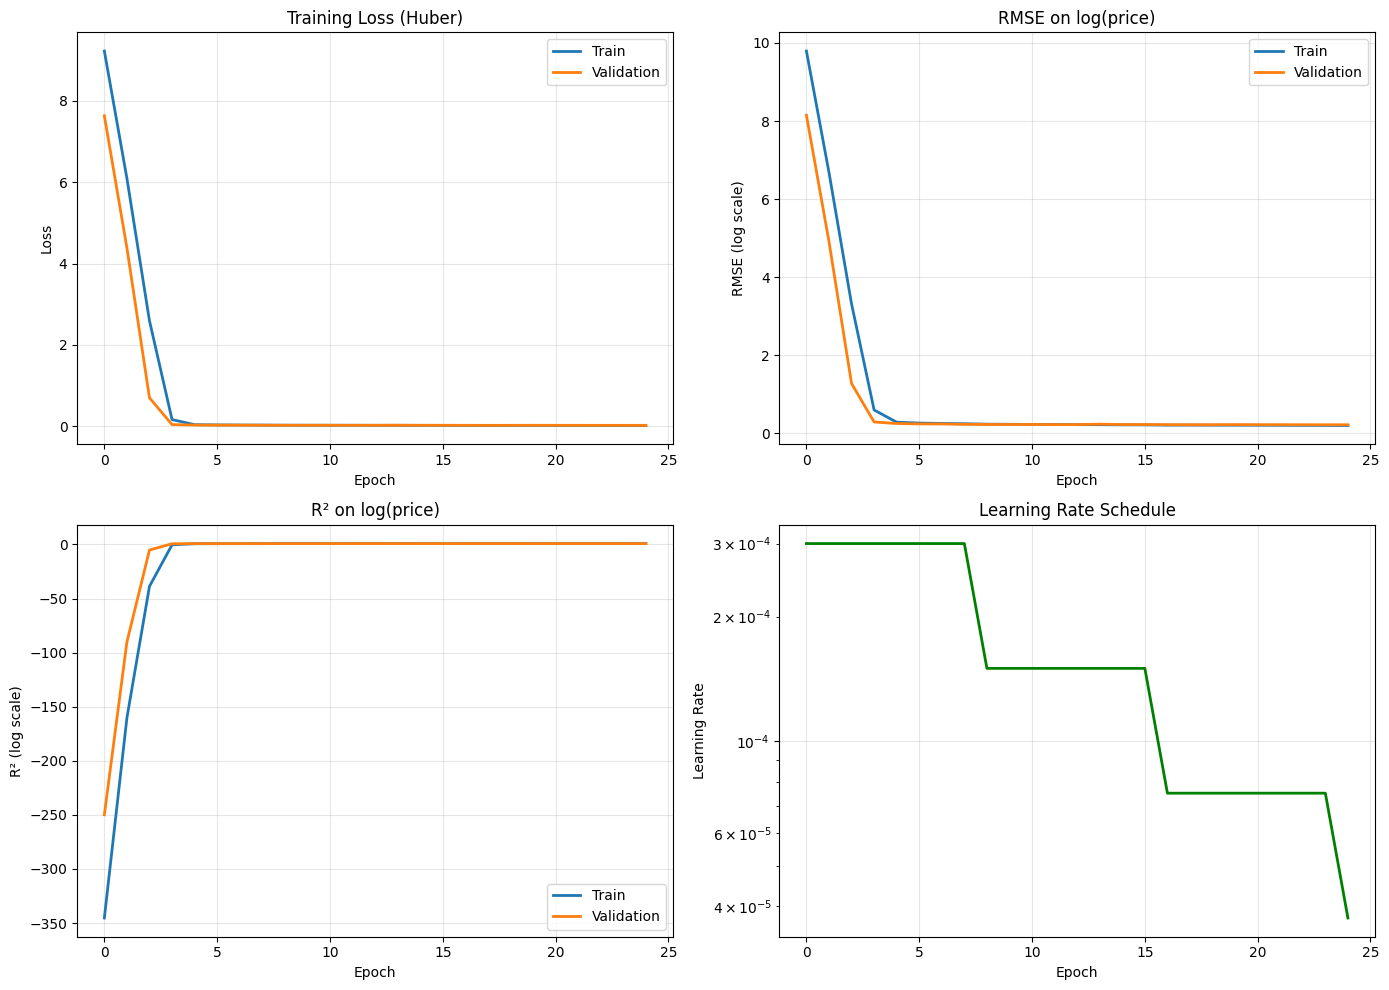

Training history saved to /Users/yashbansal/Documents/cdc/Approach_4/outputs/training_history.png


In [21]:
# Cell 20: Plot Training History
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss (Huber)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE (log scale)
axes[0, 1].plot(history['train_rmse_log'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_rmse_log'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (log scale)')
axes[0, 1].set_title('RMSE on log(price)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² (log scale)
axes[1, 0].plot(history['train_r2_log'], label='Train', linewidth=2)
axes[1, 0].plot(history['val_r2_log'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R² (log scale)')
axes[1, 0].set_title('R² on log(price)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['lr'], linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()

print(f"Training history saved to {config.OUTPUT_DIR}/training_history.png")

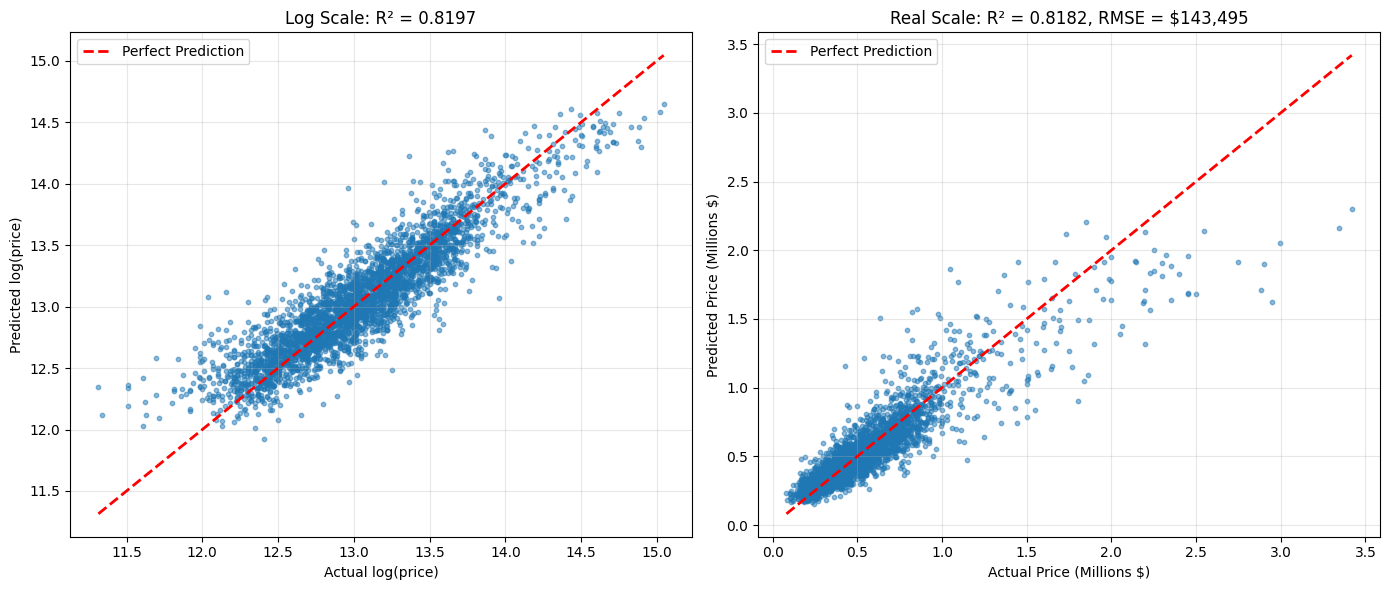

Scatter plot saved to /Users/yashbansal/Documents/cdc/Approach_4/outputs/prediction_scatter.png


In [22]:
# Cell 21: Prediction vs Actual Scatter Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale scatter
axes[0].scatter(all_targets_log, all_preds_log, alpha=0.5, s=10)
axes[0].plot([all_targets_log.min(), all_targets_log.max()], 
             [all_targets_log.min(), all_targets_log.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(price)')
axes[0].set_ylabel('Predicted log(price)')
axes[0].set_title(f'Log Scale: R² = {r2_log:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Real scale scatter
axes[1].scatter(all_targets_real / 1e6, all_preds_real / 1e6, alpha=0.5, s=10)
axes[1].plot([all_targets_real.min() / 1e6, all_targets_real.max() / 1e6], 
             [all_targets_real.min() / 1e6, all_targets_real.max() / 1e6], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price (Millions $)')
axes[1].set_ylabel('Predicted Price (Millions $)')
axes[1].set_title(f'Real Scale: R² = {r2_real:.4f}, RMSE = ${rmse_real:,.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'prediction_scatter.png'), dpi=150)
plt.show()

print(f"Scatter plot saved to {config.OUTPUT_DIR}/prediction_scatter.png")

In [27]:
# Cell 23: Generate Validation Explainability
print("Generating explainability visualizations for validation set...")

val_explain_dir = os.path.join(config.EXPLAINABILITY_DIR, 'validation')
os.makedirs(val_explain_dir, exist_ok=True)

saved_count = 0
model.eval()

# Create a mapping from id to prices
id_to_actual = dict(zip(val_results['id'], val_results['actual_price']))
id_to_pred = dict(zip(val_results['id'], val_results['predicted_price']))

for idx in tqdm(range(len(val_dataset)), desc="Generating Grad-CAM"):
    try:
        img, tabular, target, prop_id = val_dataset[idx]
        
        img = img.unsqueeze(0).to(device)
        tabular = tabular.unsqueeze(0).to(device)
        
        actual_price = np.exp(target.item())
        pred_price = id_to_pred.get(prop_id, None)
        
        if pred_price is None:
            with torch.no_grad():
                output = model(img, tabular)
                pred_price = np.exp(output.item())
        
        save_path = visualize_explainability(
            model, img, tabular, prop_id, val_explain_dir, 
            prefix='val', actual_price=actual_price, pred_price=pred_price
        )
        saved_count += 1
        
    except Exception as e:
        print(f"Error for property {prop_id}: {e}")
        continue
    
    # Clear cache periodically
    if device.type == 'mps' and idx % 50 == 0:
        torch.mps.empty_cache()
        gc.collect()

print(f"\nSaved {saved_count} explainability visualizations to {val_explain_dir}")

Generating explainability visualizations for validation set...


Generating Grad-CAM:   0%|          | 0/3242 [00:00<?, ?it/s]


Saved 3242 explainability visualizations to /Users/yashbansal/Documents/cdc/Approach_4/Explainability/validation


In [28]:
# Cell 24: Generate Test Predictions
print("Generating predictions for test set...")

model.eval()
test_predictions = []
test_ids = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Predictions"):
        img, tabular, prop_ids = batch
        img = img.to(device)
        tabular = tabular.to(device)
        
        outputs = model(img, tabular)
        
        # Convert from log(price) to original price
        prices = torch.exp(outputs).cpu().numpy()
        
        test_predictions.extend(prices)
        test_ids.extend(prop_ids.numpy())

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'id': test_ids,
    'predicted_price': test_predictions
})

# Save predictions
predictions_df.to_csv(config.PREDICTIONS_PATH, index=False)

print(f"\nTest predictions saved to {config.PREDICTIONS_PATH}")
print(f"Total test samples: {len(predictions_df)}")
print(f"\nPrediction statistics:")
print(f"  Min:    ${predictions_df['predicted_price'].min():,.0f}")
print(f"  Max:    ${predictions_df['predicted_price'].max():,.0f}")
print(f"  Mean:   ${predictions_df['predicted_price'].mean():,.0f}")
print(f"  Median: ${predictions_df['predicted_price'].median():,.0f}")

print(f"\nFirst 10 predictions:")
print(predictions_df.head(10).to_string(index=False))

Generating predictions for test set...


Test Predictions:   0%|          | 0/85 [00:00<?, ?it/s]


Test predictions saved to /Users/yashbansal/Documents/cdc/Approach_4/outputs/test_predictions.csv
Total test samples: 5404

Prediction statistics:
  Min:    $117,638
  Max:    $2,290,488
  Mean:   $537,773
  Median: $453,188

First 10 predictions:
        id  predicted_price
2591820310     3.851761e+05
7974200820     8.733860e+05
7701450110     1.220015e+06
9522300010     1.944893e+06
9510861140     7.512827e+05
1761300310     2.699042e+05
7732410120     6.613185e+05
7010701383     6.507696e+05
 291310170     4.003922e+05
4232901990     5.342421e+05
